# 第二次作业-CNN
- 许擎栋
- 2016210329

## 1. 数据预处理

### 1.1 数据导入

数据导入有两种思路：
- 1）通过将所有图片读入内存，将图片数据存在3维列表中，分别代表图片的channel，长和宽，整个列表记为x；同时存入图片的label到1维列表y中。
- 2）通过将所有图片文件写入TFrecord二进制文件中，再从队列中依次读取

在数据集不大的情况下，采用方法1）可以便捷的导入数据，而如果训练数据集很大的情况下，通过TFrecord，从队列中读入数据是更可取的方式。在助教提供的StartCode中，采用了方法1）。我自己写的代码中采用了方法2），代码片段如下，通过Writing将图片数据转化为tfrecord格式，通过read_and_decode函数取出队列中的单张图片数据和标签

In [ ]:
def Writing(datadir,nameinput):
    classes = os.listdir(datadir)
    classes.remove('.DS_Store')

    img_path_total = []
    img_label_total = []
    for name in classes:
        class_path = datadir + '/'+name + '/'
        index = int(name[5:])
        for img_name in os.listdir(class_path):
            img_path_total.append(class_path + img_name)  # 每张图片的地址
            img_label_total.append(index) #每张图片的标签
    img_total = [[img_label_total[i],img_path_total[i]] for i in range(len(img_label_total))]
    #print(img_total)
    rd.shuffle(img_total)
    #print(img_total)
    y_label, x_path = [img_total[i][0] for i in range(len(img_label_total))],[img_total[i][1] for i in range(len(img_label_total))]
    
    #for i in range(len(img_total)):
    x_train_path, x_test_path, y_train, y_test = train_test_split(x_path, y_label, test_size = 0.2)  

    writer = tf.python_io.TFRecordWriter(nameinput+'_train'".tfrecords")  # 要生成的文件
   

In [ ]:
 for i in range(len(y_train)):
            img = Image.open(x_train_path[i])
            img = img.resize((224, 224))
            img_raw = img.tobytes()  # 将图片转化为二进制格式
            example = tf.train.Example(features=tf.train.Features(feature={
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[y_train[i]])),
                'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
            }))  # example对象对label和image数据进行封装
            writer.write(example.SerializeToString())  # 序列化为字符串
    writer.close()
    
    writer = tf.python_io.TFRecordWriter(nameinput+'_test'".tfrecords")  # 要生成的文件
    for i in range(len(y_test)):
            img = Image.open(x_test_path[i])
            img = img.resize((224, 224))
            img_raw = img.tobytes()  # 将图片转化为二进制格式
            example = tf.train.Example(features=tf.train.Features(feature={
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[y_test[i]])),
                'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
            }))  # example对象对label和image数据进行封装
            writer.write(example.SerializeToString())  # 序列化为字符串
    writer.close()
    
def read_and_decode(filename): # 读入dog_train.tfrecords
    filename_queue = tf.train.string_input_producer([filename],num_epochs=30)#生成一个queue队列
 
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)#返回文件名和文件
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'img_raw' : tf.FixedLenFeature([], tf.string),
                                       })#将image数据和label取出来
 
    img = tf.decode_raw(features['img_raw'], tf.uint8)
    img = tf.reshape(img, [224, 224, 3])  #reshape为128*128的3通道图片
    img = tf.cast(img, tf.float32) * (1. / 255) - 0.5 #在流中抛出img张量
    label = tf.cast(features['label'], tf.int32) #在流中抛出label张量
    return img, label

### 1.2 形成batch

助教给的Startcode通过对读入的x和y进行分段切片得到图片的batch，而若采用队列读入的方式，可以通过如下g_batch函数，通过简单循环，将出队的图片和标签存放到一个list中，作为一个batch：

In [ ]:
def g_batches(filename,batchsize):
    img, label = read_and_decode(filename)
    min_after_dequeue = 100
    capacity = min_after_dequeue + 3*batchsize
    
    img_batch, label_batch = tf.train.shuffle_batch([img, label],
                                                   batch_size = batchsize,
                                                   capacity = capacity,
                                                   min_after_dequeue = min_after_dequeue)
    return img_batch, label_batch

## 2. 网络结构

- 完成数据输入后，就进入神经网络的设置了。由于TensorFlow使用的是静态图模型，需要先行搭建网络，建立关于输入的minibatch和标签的placeholder，如下所示：

In [ ]:
x = tf.placeholder(tf.float32,[None,128,128,3])
y = tf.placeholder(tf.int32,[None,n_classes])
keep_prob = tf.placeholder(tf.float32)

- 建立卷积网络层和全连接层，原本参考Alexnet的结构，但是计算量无法跟上，因此作罢，卷积层只建立了4层,全连接层建立1层
- 单个图像文件在预处理环节转换成224×224×3大小
- 利用tf.nn.conv2d函数进行卷积，tf.nn.relu函数作为激活，自定义了B_Norm函数作为batch normalization

### 2.1 卷积函数，最大池化函数与batch_normalization

In [ ]:
def conv2d(name, x, W, b,strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1,strides,strides,1], padding = 'SAME')
    x = tf.nn.bias_add(x,b)
    return tf.nn.relu(x,name = name)
#定义pooling
def maxpool2d(name, x, k=2):
    return tf.nn.max_pool(x,ksize = [1,k,k,1],strides=[1,k,k,1],padding = 'SAME',name = name)
#BN
def B_Norm(x):
    train_phase = self.istraining
    with tf.variable_scope(scope_bn):
        beta = tf.Variable(tf.constant(0.0, shape=[x.shape[-1]]), name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[x.shape[-1]]), name='gamma', trainable=True)
        axises = np.arange(len(x.shape) - 1).tolist()
        batch_mean, batch_var = tf.nn.moments(x, axises, name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)
        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(train_phase, mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

### 2.2 网络参数初始化

In [ ]:
#网络参数
weights = {
    'wc1': tf.Variable(tf.random_normal([5,5,3,32])),#224*224*3 ---> 112*112*32 
    'wc2': tf.Variable(tf.random_normal([5,5,32,64])), #112*112*32 ---> 56*56*64
    'wc3': tf.Variable(tf.random_normal([3,3,64,64])), #56*56*64 ---> 28*28*64
    'wc4': tf.Variable(tf.random_normal([3,3,64,64])), #28*28*64 ---> 14*14*64
    'wd1': tf.Variable(tf.random_normal([14*14*64,1024])), #14*14*64 ---> 1024*n_classes
    'out': tf.Variable(tf.random_normal([1024,n_classes]))
}
biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

### 2.3 网络搭建

In [ ]:
def cnn_net(x,weights,biases,dropout):
    x = tf.reshape(x, shape = [-1,128,128,3])
    #第一层
    conv1 = conv2d('conv1', x, weights['wc1'], biases['bc1'])
    pool1 = maxpool2d('pool1', conv1, k = 2)
    B_Norm1 = B_Norm(pool1)
    #第二层
    conv2 = conv2d('conv2',B_Norm1,weights['wc2'], biases['bc2'])
    pool2 = maxpool2d('pool2',conv2, k = 2)
    B_Norm2 = B_Norm(pool2)
    #第三层
    conv3 = conv2d('conv3',B_Norm2, weights['wc3'], biases['bc3'])
    pool3 = maxpool2d('pool3',conv3, k = 2)
    B_Norm3 = B_Norm(pool3)
    #第四层
    conv4 = conv2d('conv3',B_Norm2, weights['wc3'], biases['bc3'])
    pool4 = maxpool2d('pool3',conv3, k = 2)
    B_Norm4 = B_Norm(pool4)
    
    #全连接层1
    fc1 = tf.reshape(B_Norm4, [-1,weights['wf1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1,weights['wf1']),biases['bf1'])
    fc1 = B_Norm(fc1)
    fc1 = tf.nn.relu(fc1)
    #dropout
    fc1 = tf.nn.dropout(fc1,dropout)
    
    
    #输出
    out = tf.add(tf.matmul(fc1,weights['out']),biases['out'])
    return out

## 3. 求解

### 3.1 定义loss和优化器
通过cnn_net函数计算出预测结果，神经网络计算出的结果是每一类别的概率值，根据预测概率值最大的索引作为预测结果，计算一整个batch下预测的损失值，通过AdamOptimizer优化器对loss进行优化。Adam方法是自适应矩估计方法，该方法会通过损失函数对于每个参数的一阶矩或二阶矩动态调整每个参数的学习率

In [ ]:
pred = cnn_net(x,weights,biases,keep_prob)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred,labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

### 3.2 准确率评估

准确率评估包含了训练集准确率和验证集准确率计算，前面预处理的时候划分好了训练集train和验证集valid。验证集的准确率可以帮助我们评估模型的准确率，而对比训练集的准确率则可以评估模型是否**过拟合**，当训练集准确率过高而验证集准确率不足时，模型存在过拟合。

#### 3.2.1 训练集准确率

In [ ]:
correct_pred = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

#### 3.2.2 验证集准确率
如下代码为助教Startcode中给出的验证集计算方法，是train_wapper函数的一部分。通过对valid文件夹中的所有图片进行label预测，总计375张图片，计算整体预测准确率，当验证集的acc达到最大时，保存模型并记录最大acc。

In [ ]:
if i % 20 == 0:
    pre = list()
    tot_acc = 0
    tot_input = 0
    #while valid_set.has_next_batch():
    #    valid_img, valid_label = valid_set.next_batch()
    #    predictions, loss, acc = model.valid(valid_img, valid_label)
    #    tot_acc += acc * len(valid_img)
    #    tot_input += len(valid_img)
    valid_img, valid_label = valid_set.xs, valid_set.ys
    predictions, loss, acc = model.valid(valid_img, valid_label)
    tot_acc += acc * len(valid_img)
    tot_input += len(valid_img)
    print("tot_acc=", tot_acc, "tot_input=", tot_input)
    acc = tot_acc / tot_input
    valid_set.init_epoch()
    print("current accuracy is:", acc)
    if acc > best_accuracy:
        model.save(i)
        best_accuracy = acc

## 4.计算结果分析与讨论

### 4.1 模型验证准确率

由于总体数据集不够充足，在训练集上表现良好，在验证集上却表现的很糟糕。对于dset1和dset2，其loss关于迭代次数iteration的变化关系如附件1与附件2图所示。

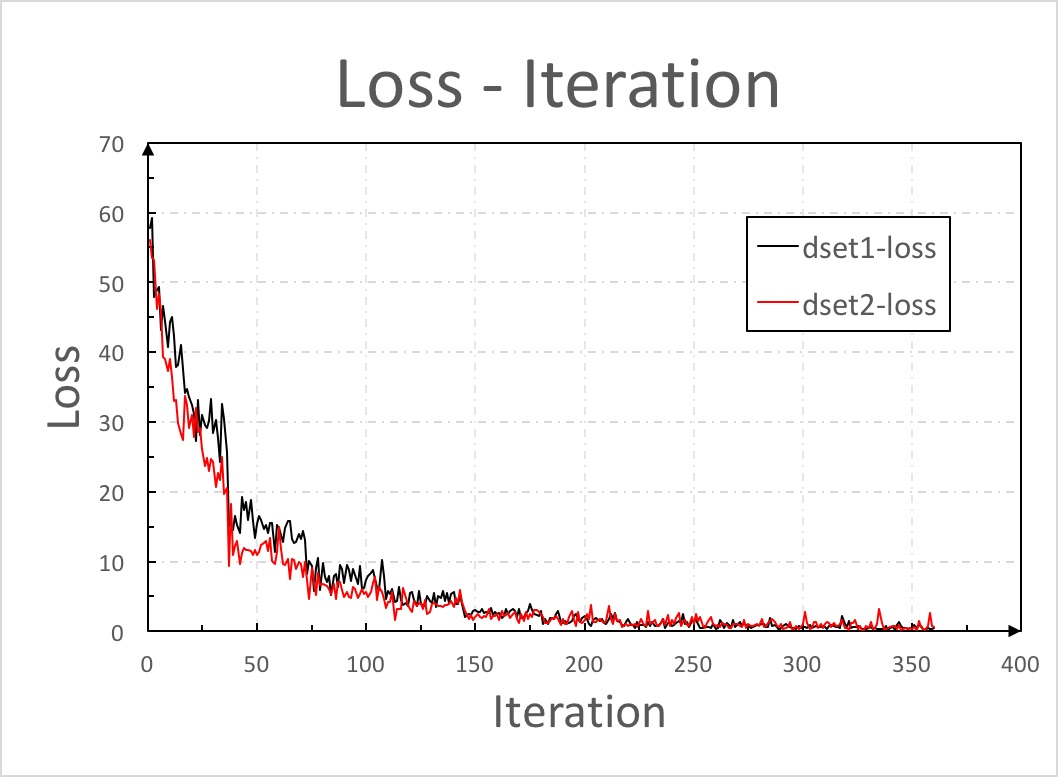

In [13]:
from IPython.display import Image
Image(filename="/Users/Optimus-Prime/Desktop/1.jpg",width=400,height=250)


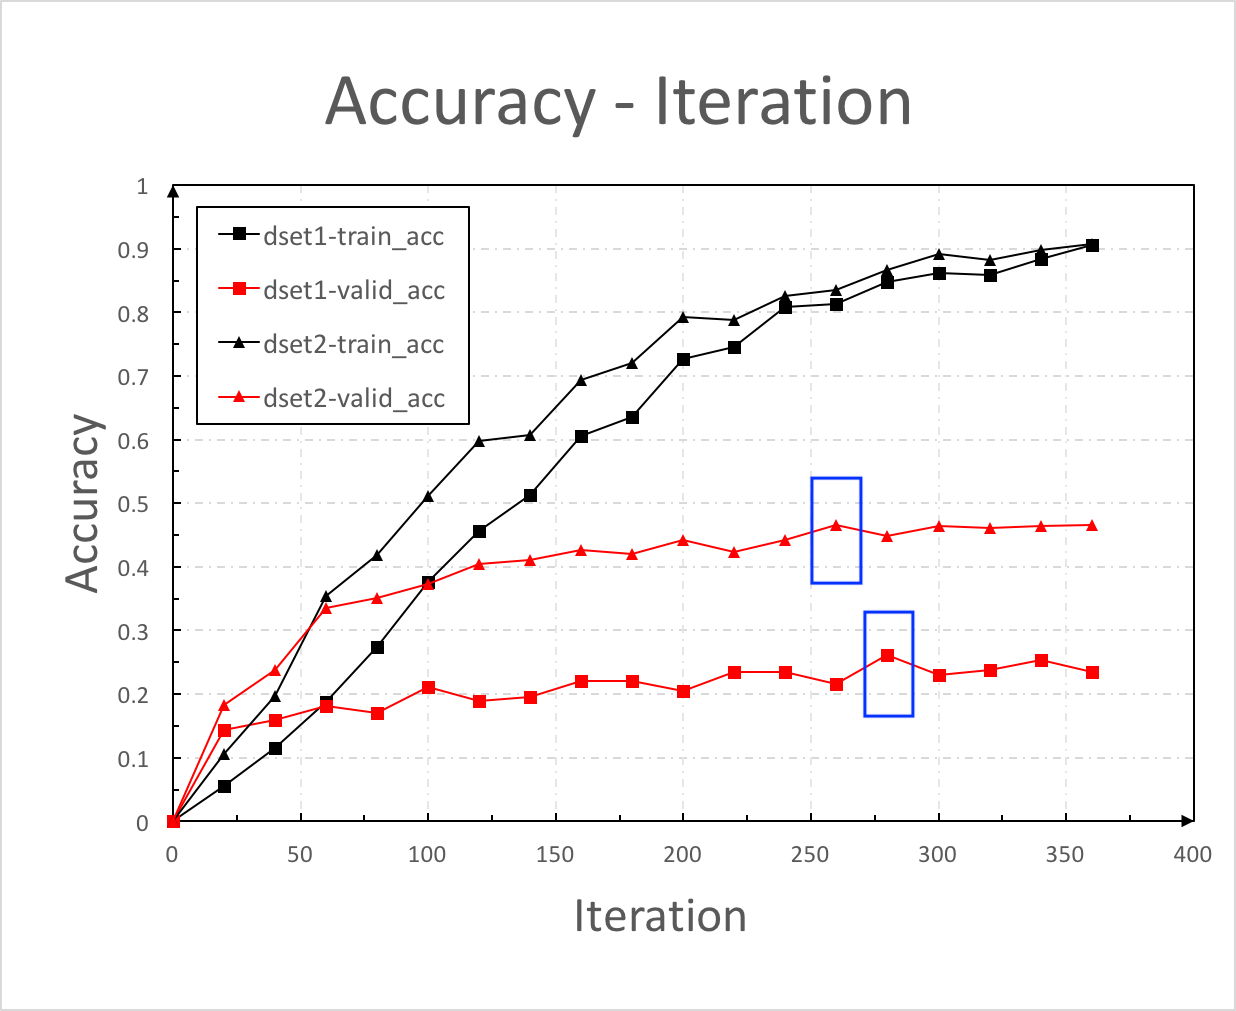

In [14]:
Image(filename="/Users/Optimus-Prime/Desktop/2.png",width =400,height=250)

### 4.2 分析讨论
从loss-iteration关系图观测发现，模型训练至150代时，loss已经降到最低值了，在接下来了210代里上下波动不再下降。对应到accuracy-iteration关系图上，150代时的模型在训练集上并未达到很高的准确率（约0.6），而验证集上的准确率却已接近饱和。从模型的选择来看，150代之后的模型在验证集上的表现几乎不发生变化，均可以作为最优模型看待。
#### 4.2.1 Batch Normalization的影响
原本建立的网络模型仅在卷积层之后设置了Batch Normalization，并未在全连接层设置。这样的模型在最后的验证集的表现上始终达不到0.1的准确率，当在全连接层输出之后添加BN，模型准确率上升到0.2，同时收敛速度更快了。这样的过程进一步说明了BN操作在每层网络计算中的重要性，简单一层设置甚至决定了结果的不同。
#### 4.2.2 数据增广
图像数据增广包含了对图像的裁剪、平移、旋转、拉伸、透视、色彩等操作，一方面增加了输入数据量有利于更准确的训练，另一方面提高了模型的泛化能力。本次实验由于服务器计算能力所限（原始数据跑100代需要15mins），并未采用数据增广的方式。
#### 4.2.3 卷积层参数
实验中尝试了3层与4层的卷积层设置，同时还试验了不同的卷积核，原参考Alexnet的卷积核，初始设置为11×11×3，然而计算时候发现，收敛速度很慢。将初始卷积核调整至5×5，发现收敛速度加快了。从原理上简单分析，可以认为较大的卷积核对图像特征的抽取更为宏观，而较小的卷积核对特征的抽取则更细致，在数据量较小的训练集中，细致的特征更有利于模型的训练。